# Solar Dynamo

In [1]:
using DataFrames
using DifferentialEquations
using SpecialFunctions
using Plots
using XLSX

In [9]:
# Definisci il DataFrame con i nomi delle colonne
df = DataFrame(
    year = Int[],
    open_magn_flux = Float64[],
    open_magn_flux_err = Float64[],
    ssa_open_magn_flux = Float64[],
    sunsopts_num = Float64[],
    sunspots_err = Float64[],
    ssa_sunspots = Float64[]
)

# Apri il file e leggi i dati
XLSX.openxlsx("SN Usoskin Brehm.xlsx") do file
    sheet = file["Data"] 

    for row in XLSX.eachrow(sheet)
        if isa(row[2], Number)
            push!(df, (
                year = row[2],
                open_magn_flux = row[3],
                open_magn_flux_err = row[4],
                ssa_open_magn_flux = row[5],
                sunsopts_num = row[7],
                sunspots_err = row[8],
                ssa_sunspots = row[9]
            ))
        end
    end
end

first(df,5)


5×7 DataFrame
 Row │ year   open_magn_flux  open_magn_flux_err  ssa_open_magn_flux  sunsopts ⋯
     │ Int64  Float64         Float64             Float64             Float64  ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │   971            7.86                1.65                5.29         1 ⋯
   2 │   972            4.94                1.06                5.36
   3 │   973            3.08                1.24                5.45
   4 │   974            1.9                 1.39                5.56         -
   5 │   975            1.26                1.44                5.65         - ⋯
                                                               3 columns omitted

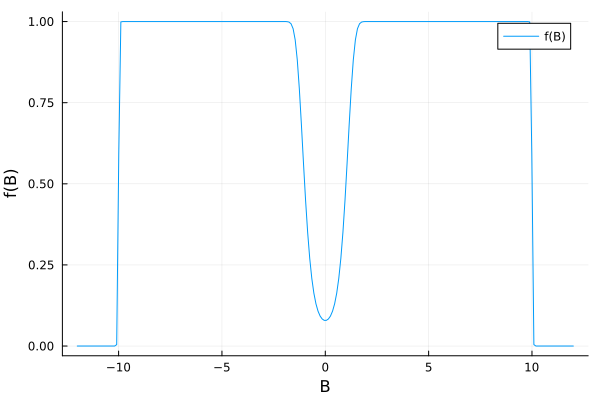

In [3]:
# BOX-SHAPED FUNCTION FOR THE MAGNETIC FIELD RANGE 

# Define limits
B_min = 1
B_max = 10

# Define the function
function f(B)
    return 1 / 4 * (1 .+ erf.(B .^ 2 .- B_min ^ 2)) .* (1 .- erf.(B .^ 2 .- B_max ^ 2))
end

# Plot (range [-12, 12])
B_values = range(-12, stop = 12, length = 240)
f_values = f(B_values)
plot(B_values, f_values, xlabel = "B", ylabel = "f(B)", label = "f(B)")

┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\lucre\.julia\packages\SciMLBase\QEvkv\src\integrator_interface.jl:597


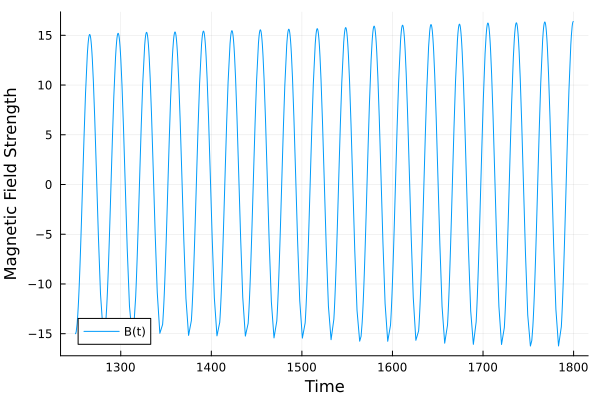

In [41]:
# DDE PROBLEM WITHOUT NOISE AND PERIODIC MODULATION

# Define parameters
N = -3.4803
q = -5.0789
tau = 5
p = [N, q, tau]

# Define initial conditions
B0 = [-15, 0, 0]
tspan = (1250, 2050.0)
h(p, t) = [0.0, 0.0, 0.0]

# Define the function for the DDE
function MagneticField(du, u, h, p, t)
  N, q, tau = p

  B = u[1]
  dB = u[2]
  ddB = u[3]

  du[1] = ddB
  du[2] = -2 * dB
  du[3] = (- B - N * h(p, t - q)[1] * f(h(p, t - q)[1])) / (tau^2)
end

# Define and solve the DDE problem
prob = DDEProblem(MagneticField, B0, h, tspan, p)
sol = solve(prob, MethodOfSteps(Tsit5()))

# Plot 
plot(sol.t, sol[1, :], label = "B(t)", xlabel = "Time", ylabel = "Magnetic Field Strength", linewidth = 1)

In [10]:
y_obs = df.sunsopts_num
using DifferentialEquations, Turing, Distributions


# Riformulazione dell'ODE in forma di primo ordine
function sunspot_ode!(du, u, p, t)
    B, dB_dt = u
    N, q = p
    du[1] = dB_dt
    du[2] = -N * f(B) * B - dB_dt
end

# Modello Bayesian con Turing
@model function bayesian_model(y_obs)
    N ~ Normal(0, 10)
    q ~ Normal(0, 10)

    # Condizioni iniziali e setup ODE
    B0 = [y_obs[1], 0.0]
    tspan = (0.0, length(y_obs))
    p = [N, q]
    
    # Risolvi l'ODE
    prob = ODEProblem(sunspot_ode!, B0, tspan, p)
    solution = solve(prob, Tsit5(), saveat = 1.0)
    B_solution = [sol[1] for sol in solution.u]

    # Likelihood
    for i in 1:length(y_obs)
        y_obs[i] ~ Normal(B_solution[i], 1.0)
    end
end

# Esecuzione MCMC
model = bayesian_model(y_obs)
chain = sample(model, NUTS(), 500)

Sampling   0%|█                                         |  ETA: N/A
┌ Info: Found initial step size
│   ϵ = 25.6
└ @ Turing.Inference C:\Users\lucre\.julia\packages\Turing\YlElu\src\mcmc\hmc.jl:191
Sampling   0%|█                                         |  ETA: 0:31:32
Sampling   1%|█                                         |  ETA: 0:15:45
Sampling   1%|█                                         |  ETA: 0:10:28
Sampling   2%|█                                         |  ETA: 0:07:49
Sampling   2%|█                                         |  ETA: 0:06:15
Sampling   2%|██                                        |  ETA: 0:05:11
Sampling   3%|██                                        |  ETA: 0:04:26
Sampling   3%|██                                        |  ETA: 0:03:52
Sampling   4%|██                                        |  ETA: 0:03:26
Sampling   4%|██                                        |  ETA: 0:03:05
Sampling   4%|██                                        |  ETA: 0:02:48
Sampling  

Chains MCMC chain (500×14×1 Array{Float64, 3}):

Iterations        = 251:1:750
Number of chains  = 1
Samples per chain = 500
Wall duration     = 10.05 seconds
Compute duration  = 10.05 seconds
parameters        = N, q
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std      mcse   ess_bulk   ess_tail      rhat   e ⋯
      Symbol   Float64   Float64   Float64    Float64    Float64   Float64     ⋯

           N   -0.6520   10.6670    0.5206   415.8425   294.2157    1.0109     ⋯
           q    0.3620   10.7241    0.4790   501.6991   279.0117    1.0139     ⋯
                                                                1 column omitted

Quantiles
  parameters       2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol    Float64   Float64   Float64   Float64   Float64 

          

In [18]:
using Statistics

# Estrai i parametri dalla catena
N_mean = mean(chain[:N])
q_mean = mean(chain[:q])
# Definizione dell'ODE con i parametri estratti
function sunspot_ode_estimated!(du, u, p, t)
    B, dB_dt = u
    N, q = p
    du[1] = dB_dt
    du[2] = -N * f(B) * B - dB_dt
end

B0_estimated = [y_obs[1], 0.0]  
tspan_estimated = (0.0, length(y_obs) - 1.0)
p_estimated = [N_mean, q_mean]

# Risoluzione dell'ODE con i parametri stimati
prob_estimated = ODEProblem(sunspot_ode_estimated!, B0_estimated, tspan_estimated, p_estimated)
solution_estimated = solve(prob_estimated, Tsit5(), saveat = 1.0)

retcode: Success
Interpolation: 1st order linear
t: 929-element Vector{Float64}:
   0.0
   1.0
   2.0
   3.0
   4.0
   5.0
   6.0
   7.0
   8.0
   9.0
   ⋮
 920.0
 921.0
 922.0
 923.0
 924.0
 925.0
 926.0
 927.0
 928.0
u: 929-element Vector{Vector{Float64}}:
 [120.5, 0.0]
 [120.5, 0.0]
 [120.5, 0.0]
 [120.5, 0.0]
 [120.5, 0.0]
 [120.5, 0.0]
 [120.5, 0.0]
 [120.5, 0.0]
 [120.5, 0.0]
 [120.5, 0.0]
 ⋮
 [120.5, 0.0]
 [120.5, 0.0]
 [120.5, 0.0]
 [120.5, 0.0]
 [120.5, 0.0]
 [120.5, 0.0]
 [120.5, 0.0]
 [120.5, 0.0]
 [120.5, 0.0]

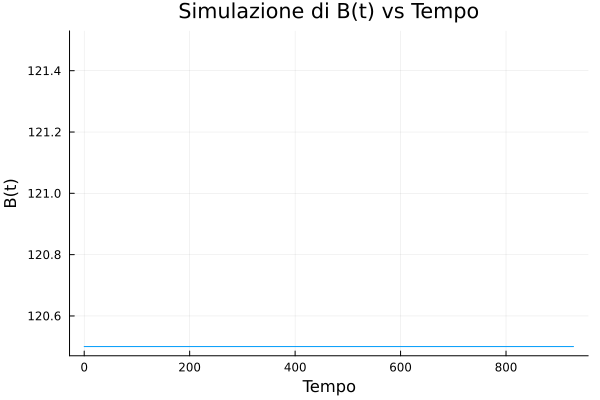

In [19]:
using Plots

# Estrazione dei dati dalla soluzione
t_vals = collect(range(tspan_estimated[1], tspan_estimated[2], length = length(solution_estimated.u)))
B_vals = [sol[1] for sol in solution_estimated.u]

# Creazione del grafico
plot(t_vals, B_vals, title = "Simulazione di B(t) vs Tempo", xlabel = "Tempo", ylabel = "B(t)", legend = false)

In [40]:
y_obs = df.sunsopts_num
using DifferentialEquations, Turing, Distributions


# Riformulazione dell'ODE in forma di primo ordine
function sunspot_ode!(du, u, p, t)
    B, dB, ddB = u
    N, q = p
    du[1] = ddB
    du[2] = -2 * dB
    du[3] = -B - N * f(B) * B
end
@model function bayesian_model(y_obs)
    N ~ Normal(0, 10)
    q ~ Normal(0, 10)

    # Condizioni iniziali e setup ODE
    B0 = [y_obs[1], 0.0, 0.0]
    tspan = (0.0, length(y_obs))
    p = [N, q]
    
    # Risolvi l'ODE
    prob = ODEProblem(sunspot_ode!, B0, tspan, p)
    solution = solve(prob, Tsit5(), saveat = 1.0)
    B_solution = [sol[1] for sol in solution.u]

    # Likelihood
    for i in 1:length(y_obs)
        y_obs[i] ~ Normal(B_solution[i], 1.0)
    end
end

# Esecuzione MCMC
model = bayesian_model(y_obs)
chain = sample(model, NUTS(), 500)

Sampling   0%|█                                         |  ETA: N/A
┌ Info: Found initial step size
│   ϵ = 6.8724264159230426e-6
└ @ Turing.Inference C:\Users\lucre\.julia\packages\Turing\YlElu\src\mcmc\hmc.jl:191
Sampling   0%|█                                         |  ETA: 0:04:55
Sampling   1%|█                                         |  ETA: 0:02:29
Sampling   1%|█                                         |  ETA: 0:01:43
Sampling   2%|█                                         |  ETA: 0:01:19
Sampling   2%|█                                         |  ETA: 0:01:05
Sampling   2%|██                                        |  ETA: 0:05:09
Sampling   3%|██                                        |  ETA: 0:08:07
Sampling   3%|██                                        |  ETA: 0:10:22
Sampling   4%|██                                        |  ETA: 0:18:13
Sampling   4%|██                                        |  ETA: 0:19:08
Sampling   4%|██                                        |  ETA: 0

Chains MCMC chain (500×14×1 Array{Float64, 3}):

Iterations        = 251:1:750
Number of chains  = 1
Samples per chain = 500
Wall duration     = 4189.65 seconds
Compute duration  = 4189.65 seconds
parameters        = N, q
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std      mcse   ess_bulk   ess_tail      rhat   e ⋯
      Symbol   Float64   Float64   Float64    Float64    Float64   Float64     ⋯

           N   -3.4803    0.0000       NaN        NaN        NaN       NaN     ⋯
           q   -5.0789    0.0000    0.0000     9.1453        NaN    1.0507     ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

        